In [1]:
#!pip install PIL
#!pip install tensorboardX

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pprint
import math
from lamb import Lamb

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#Constants
dataset_path = './Data-L'
batch_size = 32
epoch = 100
load_workers = 2 
lr = 1e-3
weight_decay = 1e-6
cuda = torch.device("cuda:2")
print(cuda)
best_epoch = 0
tag = 1
meta_beta = 10.0
m = 3

cuda:2


In [5]:
figure_configuration_names = ['center_single', 'distribute_four', 'in_distribute_four_out_center_single', 'left_center_single_right_center_single']
#figure_configuration_names = ['center_single']

class ToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)

class RAVENdataset(Dataset):
    def __init__(self, root_dir, dataset_type, figure_configurations, img_size, transform=None, shuffle=False):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = []
        for idx in figure_configurations:
            tmp = [f for f in glob.glob(os.path.join(root_dir, figure_configuration_names[idx], "*.npz")) if dataset_type in os.path.basename(f)]
            self.file_names += tmp
        self.img_size = img_size   
        self.shuffle = shuffle
        self.switch = [3,4,5,0,1,2,6,7]         

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        data_path = self.file_names[idx]
        data = np.load(data_path)
        image = data["image"].reshape(16, 160, 160)
        target = data["target"]
        meta_target = data["meta_target"]

        if self.shuffle:
            context = image[:8, :, :]
            choices = image[8:, :, :]
            indices = np.arange(8)
            np.random.shuffle(indices)
            new_target = np.where(indices == target)[0][0]
            new_choices = choices[indices, :, :]
            switch_2_rows = np.random.rand()            
            if switch_2_rows < 0.5:                
                context = context[self.switch, :, :]
            image = np.concatenate((context, new_choices))
            target = new_target

        resize_image = []
        for idx in range(0, 16):
            resize_image.append(np.array(Image.fromarray(image[idx,:,:]).resize([self.img_size, self.img_size])))
            #resize_image.append(misc.imresize(image[idx,:,:], (self.img_size, self.img_size)))
        resize_image = np.stack(resize_image) 

        del data
        if self.transform:
            resize_image = self.transform(resize_image)           
            target = torch.tensor(target, dtype=torch.long)
            meta_target = self.transform(meta_target) 

        return resize_image, target, meta_target

In [6]:
    img_size = 80
    train_figure_configurations = [0]
    val_figure_configurations = train_figure_configurations
    test_figure_configurations = [0]
    print(dataset_path)
    train = RAVENdataset(dataset_path, "train", train_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]), shuffle = True)
    valid = RAVENdataset(dataset_path, "val", val_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]))
    test = RAVENdataset(dataset_path, "test", test_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]))
  

./Data-L


In [7]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=load_workers)
validloader = DataLoader(valid, batch_size=batch_size, shuffle=False, num_workers=load_workers)
testloader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=load_workers)

In [8]:
# model adapted from WReN and MLRN code: 
# WReN: https://github.com/Fen9/WReN/tree/master/models
# MLRN: https://arxiv.org/abs/2003.11608

In [9]:
def getCombinations(inputTensor, N, c, d):#input shape=(batch_size, obj_count, obj_dim) #batch_size=N, obj_count=c, obj_dim=d
    tensorA = inputTensor.reshape(N, 3, 3, d)
    tensorB = torch.roll(tensorA,1,1)
    tensorC = torch.roll(tensorB,1,1)
    tensorX = tensorA.transpose(1,2)
    tensorY = torch.roll(tensorX,1,1)
    tensorZ = torch.roll(tensorY,1,1)
    return torch.cat((torch.cat((tensorA,tensorA),3), torch.cat((tensorB,tensorA),3), torch.cat((tensorB,tensorC),3), 
                      torch.cat((tensorX,tensorX),3), torch.cat((tensorY,tensorX),3), torch.cat((tensorY,tensorZ),3)),1)
    

def getSecondaryCombinations(inputTensor, N, c, d):
  tensorA = inputTensor.reshape(N,1,c,d).expand(N,c,c,d)
  tensorB = tensorA.transpose(1, 2)

  return torch.cat((tensorB, tensorA), 3)

In [10]:
## Optimizer related changes
def add_module_params_with_decay(module, weight_decay, param_groups):
    group_with_decay= []
    group_without_decay = []
    for name, param in module.named_parameters():
        if not param.requires_grad: continue
        if name == 'bias' or name.endswith('bias'):
            group_without_decay.append(param)
        else:
            group_with_decay.append(param)
    param_groups.append({"params": group_with_decay, "weight_decay":weight_decay})
    param_groups.append({"params": group_without_decay})

optimizer_param_groups = []

In [11]:
class BasicModel(nn.Module):
    def __init__(self, args):
        super(BasicModel, self).__init__()
        self.name = args['model']

    def load_model(self, path, epoch):
        self.state_dict = torch.load(path+'{}_epoch_{}.pth'.format(self.name, epoch))

    def save_model(self, path, epoch):
        torch.save(self.state_dict(), path+'{}_epoch_{}.pth'.format(self.name, epoch))

    def compute_loss(self, output, target, meta_target):
        pass

    def train_(self, input, target, meta_target):
        self.optimizer.zero_grad()
        output = self(input)
        loss = self.compute_loss(output, target, meta_target)
        loss.backward()
        self.optimizer.step()
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return loss.item(), accuracy

    def validate_(self, input, target, meta_target):
        output = self(input)
        loss = self.compute_loss(output, target, meta_target)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return loss.item(), accuracy

    def test_(self, input, target, meta_target):
        output = self(input)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return accuracy

In [12]:
class WReN(BasicModel):
    def __init__(self, args):
        super(WReN, self).__init__(args)
        self.relation_network_depth = args['m']

        self.g_dim = 512
        self.h_dim = 256
        self.f_dim = 256

        self.use_mag_enc = True #switch between scalar input and magnitude encoded input
        self.mag_enc_type_relu = False #switch between gaussian magnitude encoding and relu based magnitude encoding

        self.magnitude_encoding_dim = 20
        #model
        #magnitude encoding
        self.input_scale = 2.0/255.0
        self.input_offset = -1.0
        std_dev = 0.28
        self.input_encoding_variance_inv = 1.0 / (math.sqrt(2.0) * std_dev)
        self.normalization_factor = 1.0 / (math.sqrt(2*math.pi) * std_dev)
        self.mag_scale = torch.nn.Parameter(torch.linspace(-1.0, 1.0, steps=self.magnitude_encoding_dim), requires_grad=False)

        if self.use_mag_enc:
            conv_input_dim = self.magnitude_encoding_dim
        else:
            conv_input_dim = 1

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(conv_input_dim, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU()
        )
        self.post_cnn_linear = torch.nn.Linear(32*4*4, 256-9)

        self.tag_matrix = torch.nn.Parameter(torch.eye(9).repeat(8, 1), requires_grad=False)

        self.g = torch.nn.Sequential(
                torch.nn.Linear(2*256, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.h_dim), 
                torch.nn.LeakyReLU()
            )

        h = []
        for i in range(m):
            rel_layer_func = torch.nn.Sequential(
                torch.nn.Linear(2*self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU()
            )
            h.append(rel_layer_func)

        self.h = torch.nn.ModuleList(h)

        f_in_dim = self.h_dim
        self.f = torch.nn.Sequential(
                torch.nn.Linear(f_in_dim, self.f_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.f_dim, self.f_dim), 
                torch.nn.LeakyReLU()
            )

        self.f_final = torch.nn.Linear(self.f_dim, 1)
        self.optimizer = None
        self.initialize_optimizer()
        
        
    def initialize_optimizer(self):
        add_module_params_with_decay(self.conv, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.post_cnn_linear,  weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.g, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.h, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.f, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.f_final, weight_decay,optimizer_param_groups)
        
        self.optimizer = Lamb(optimizer_param_groups, lr=lr)


    def compute_loss(self, output, target, meta_target):
      lossFunc = torch.nn.CrossEntropyLoss()
      answer = output[0]
      activation_loss = output[1]
      loss = lossFunc(answer,target) + activation_loss * 2e-3
      return loss

    def forward(self, batch):
        batch_size = batch.size()[0]
        #Panel preprocessor CNN
        batch_flat = batch.reshape(batch_size*16, 1, 80, 80)

        if self.use_mag_enc:
            with torch.no_grad():
                #magnitude encoding
                batch_flat = batch_flat.transpose(1, 3)
                if self.mag_enc_type_relu:
                    #first order
                    batch_flat = batch_flat.add_(255/self.magnitude_encoding_dim)
                    batch_flat = torch.nn.functional.relu_(batch_flat.mul_(self.input_scale).add_(self.input_offset).add(-self.mag_scale))
                    #second order
                    batch_flat = torch.cat((batch_flat[:, :, :, :-1] - 2*batch_flat[:, :, :, 1:], batch_flat[:, :, :, -1].unsqueeze(dim=-1)), dim=-1).mul_(self.magnitude_encoding_dim/2)
                    batch_flat = torch.nn.functional.relu_(batch_flat)
                else:
                    batch_flat = batch_flat.mul_(self.input_scale).add_(self.input_offset).tanh_().add(self.mag_scale).mul_(self.input_encoding_variance_inv).pow_(2).mul_(-1).exp_().mul_(self.normalization_factor)
                batch_flat = batch_flat.transpose(3, 1)

        conv_out = self.conv(batch_flat)
        #scatter context
        objectsWithoutPos = self.post_cnn_linear(conv_out.reshape(batch_size*16, -1))
        panel_vectors = objectsWithoutPos.reshape(batch_size, 16, 256-9)
        given, option1, option2, option3, option4, option5, option6, option7, option8 = panel_vectors.split((8, 1, 1, 1, 1, 1, 1, 1, 1), dim=1)
        optionsWithContext = torch.cat((
            given, option1, 
            given, option2, 
            given, option3, 
            given, option4, 
            given, option5, 
            given, option6, 
            given, option7, 
            given, option8
        ), 1)
        optionsWithoutPos = optionsWithContext.reshape(batch_size*8*9, 256-9)
        objects = torch.cat((optionsWithoutPos, self.tag_matrix.repeat(batch_size, 1)), dim=1).reshape(batch_size*8, 9, 256-9+9)

        #MLRN
        objRows = getCombinations(objects, batch_size*8, 9, 256)
        objRows = objRows.reshape(batch_size*8*(18*3), 2*256)

        gResult = self.g(objRows)#apply MLP

        prev_result = gResult
        prev_dim = self.h_dim
        prev_result_2d = prev_result.reshape(batch_size*8, 18, 3, prev_dim)
        sum_j = prev_result_2d.sum(dim=2)
        for i, h_layer in enumerate(self.h):
            residual = sum_j
            intermed_obj_row_pairs = getSecondaryCombinations(sum_j, batch_size*8, 18, prev_dim)
            intermed_obj_pairs = intermed_obj_row_pairs.reshape(batch_size*8*(18*18), 2*prev_dim)
            prev_result = h_layer(intermed_obj_pairs)#apply MLP
            prev_dim = self.h_dim
            prev_result_2d = prev_result.reshape(batch_size*8, 18, 18, prev_dim)
            sum_j = prev_result_2d.sum(dim=2)

        hSum = sum_j.sum(dim=1)
        result = self.f_final(self.f(hSum))#pre-softmax scores for every possible answer

        answer = result.reshape(batch_size, 8)

        #attempt to stabilize training (avoiding inf value activations in last layers) 
        activation_loss = hSum.pow(2).mean() + result.pow(2).mean()

        return answer, activation_loss

In [13]:
args = {
    'model': 'WReN',
    'm': m
}
model = WReN(args).to(cuda)


def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    train_iter = iter(trainloader)
    for _ in tqdm(range(len(train_iter))):
        counter += 1
        image, target, meta_target = next(train_iter)
        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        loss, acc = model.train_(image, target, meta_target)
        # print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Avg Training Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    loss_all = 0.0
    counter = 0
    valid_iter = iter(validloader)
    for _ in tqdm(range(len(valid_iter))):
        counter += 1
        image, target, meta_target = next(valid_iter)

        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
        loss_all += loss
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)
   
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    test_iter = iter(testloader)
    for _ in tqdm(range(len(test_iter))):
        counter += 1
        image, target, meta_target = next(test_iter)
        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)


def main():
    pp = pprint.PrettyPrinter(indent=4)
    training_dict = {}
    validation_dict = {}
    testing_dict = {}
    best_val_loss = float('inf')
    for e in range(0, epoch):
        print("Epoch: " + str(e))
        training_dict[e] = {}
        validation_dict[e] = {}
        testing_dict[e] = {}

        train_loss, train_acc = train(e)
        training_dict[e]['train_loss'] = train_loss
        training_dict[e]['train_acc'] = train_acc

        val_loss, val_acc = validate(e)
        validation_dict[e]['val_loss'] = val_loss
        validation_dict[e]['val_acc'] = val_acc

        test_acc = test(e)
        testing_dict[e]['test_acc'] = test_acc
        """
        # early stopping 
        if e > 0: 
            if val_loss <= best_val_loss: 
                best_val_loss = val_loss
                best_epoch = e
                es = 0
                torch.save(model.state_dict(), "model_" + str(e) + 'weight.pt')
            else:
                es += 1
                print("Counter {} of 10".format(es))
                # patience
                if es > 9: 
                    print("Early stopping with minimized val loss: ", best_val_loss, "and val_loss for this epoch: ", val_loss, "...")
                    break 

        loss = {'train':train_loss, 'val':val_loss}
        acc = {'train':train_acc, 'val':val_acc, 'test':test_acc}
        """
        #log.write_scalars('Loss', loss, e)
        #log.write_scalars('Accuracy', acc, e)
    return training_dict, validation_dict, testing_dict, best_epoch  
training_dict, validation_dict, testing_dict, best_epoch = main()

Epoch: 0


  0%|          | 0/188 [00:00<?, ?it/s]/common/home/ap1933/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554782469/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|██████████| 188/188 [00:40<00:00,  4.70it/s]

Avg Training Loss: 2.108262, Acc: 13.0984



100%|██████████| 63/63 [00:07<00:00,  8.94it/s]


Total Validation Loss: 4.159022, Acc: 13.3433


100%|██████████| 63/63 [00:07<00:00,  8.98it/s]


Total Testing Acc: 12.1528
Epoch: 1


100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


Avg Training Loss: 2.079529, Acc: 12.4834


100%|██████████| 63/63 [00:07<00:00,  8.33it/s]

Total Validation Loss: 4.159509, Acc: 12.0536



100%|██████████| 63/63 [00:07<00:00,  8.22it/s]


Total Testing Acc: 12.7976
Epoch: 2


100%|██████████| 188/188 [00:34<00:00,  5.51it/s]


Avg Training Loss: 2.079443, Acc: 13.5140


100%|██████████| 63/63 [00:07<00:00,  8.59it/s]

Total Validation Loss: 4.153498, Acc: 17.6091



100%|██████████| 63/63 [00:07<00:00,  8.26it/s]


Total Testing Acc: 16.9643
Epoch: 3


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]

Avg Training Loss: 1.867347, Acc: 20.5120



100%|██████████| 63/63 [00:12<00:00,  5.20it/s]


Total Validation Loss: 3.381671, Acc: 23.4623


100%|██████████| 63/63 [00:06<00:00,  9.51it/s]

Total Testing Acc: 24.2063
Epoch: 4



100%|██████████| 188/188 [00:20<00:00,  9.19it/s]


Avg Training Loss: 1.640584, Acc: 26.7453


100%|██████████| 63/63 [00:07<00:00,  8.97it/s]


Total Validation Loss: 3.254368, Acc: 25.0000


100%|██████████| 63/63 [00:06<00:00,  9.50it/s]

Total Testing Acc: 26.1905
Epoch: 5



100%|██████████| 188/188 [00:37<00:00,  5.00it/s]


Avg Training Loss: 1.587867, Acc: 28.5406


100%|██████████| 63/63 [00:06<00:00,  9.48it/s]


Total Validation Loss: 3.085792, Acc: 29.6131


100%|██████████| 63/63 [00:06<00:00,  9.11it/s]

Total Testing Acc: 30.8036
Epoch: 6



100%|██████████| 188/188 [00:29<00:00,  6.40it/s]


Avg Training Loss: 1.548634, Acc: 32.2972


100%|██████████| 63/63 [00:06<00:00,  9.12it/s]


Total Validation Loss: 3.013218, Acc: 33.2341


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]

Total Testing Acc: 33.2837
Epoch: 7



100%|██████████| 188/188 [00:39<00:00,  4.74it/s]


Avg Training Loss: 1.511772, Acc: 34.2753


100%|██████████| 63/63 [00:06<00:00, 10.21it/s]

Total Validation Loss: 2.961651, Acc: 35.5159



100%|██████████| 63/63 [00:05<00:00, 10.66it/s]


Total Testing Acc: 36.4087
Epoch: 8


100%|██████████| 188/188 [00:37<00:00,  5.05it/s]


Avg Training Loss: 1.462776, Acc: 37.7327


100%|██████████| 63/63 [00:06<00:00, 10.47it/s]


Total Validation Loss: 2.928605, Acc: 36.7063


100%|██████████| 63/63 [00:05<00:00, 10.92it/s]


Total Testing Acc: 36.0615
Epoch: 9


100%|██████████| 188/188 [00:35<00:00,  5.30it/s]


Avg Training Loss: 1.415340, Acc: 40.9242


100%|██████████| 63/63 [00:05<00:00, 10.61it/s]

Total Validation Loss: 2.808427, Acc: 43.3532



100%|██████████| 63/63 [00:06<00:00, 10.23it/s]


Total Testing Acc: 41.2202
Epoch: 10


100%|██████████| 188/188 [00:33<00:00,  5.69it/s]


Avg Training Loss: 1.350070, Acc: 43.4176


100%|██████████| 63/63 [00:06<00:00,  9.88it/s]


Total Validation Loss: 2.697774, Acc: 47.4206


100%|██████████| 63/63 [00:05<00:00, 10.55it/s]

Total Testing Acc: 44.9901
Epoch: 11



100%|██████████| 188/188 [00:31<00:00,  5.94it/s]


Avg Training Loss: 1.235402, Acc: 51.1636


100%|██████████| 63/63 [00:05<00:00, 10.68it/s]


Total Validation Loss: 2.293794, Acc: 58.1349


100%|██████████| 63/63 [00:05<00:00, 11.06it/s]


Total Testing Acc: 55.6052
Epoch: 12


100%|██████████| 188/188 [00:32<00:00,  5.87it/s]


Avg Training Loss: 1.075813, Acc: 61.1203


100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Total Validation Loss: 2.267472, Acc: 64.4841


100%|██████████| 63/63 [00:05<00:00, 10.92it/s]

Total Testing Acc: 63.0952
Epoch: 13



100%|██████████| 188/188 [00:29<00:00,  6.38it/s]


Avg Training Loss: 0.950475, Acc: 67.2207


100%|██████████| 63/63 [00:05<00:00, 10.60it/s]


Total Validation Loss: 1.764948, Acc: 70.1885


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Total Testing Acc: 66.7659
Epoch: 14



100%|██████████| 188/188 [00:29<00:00,  6.30it/s]


Avg Training Loss: 0.866286, Acc: 69.7307


100%|██████████| 63/63 [00:06<00:00,  9.67it/s]


Total Validation Loss: 1.875870, Acc: 68.4524


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]

Total Testing Acc: 65.6250
Epoch: 15



100%|██████████| 188/188 [00:31<00:00,  5.99it/s]

Avg Training Loss: 0.818746, Acc: 71.5758



100%|██████████| 63/63 [00:07<00:00,  8.55it/s]


Total Validation Loss: 1.615429, Acc: 73.5615


100%|██████████| 63/63 [00:06<00:00,  9.05it/s]


Total Testing Acc: 72.9663
Epoch: 16


100%|██████████| 188/188 [00:40<00:00,  4.59it/s]


Avg Training Loss: 0.783653, Acc: 72.5898


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]

Total Validation Loss: 1.650489, Acc: 72.3710



100%|██████████| 63/63 [00:11<00:00,  5.71it/s]

Total Testing Acc: 70.9325
Epoch: 17



100%|██████████| 188/188 [00:21<00:00,  8.90it/s]

Avg Training Loss: 0.739451, Acc: 74.5678



100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


Total Validation Loss: 1.591683, Acc: 73.1151


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]

Total Testing Acc: 72.3710
Epoch: 18



100%|██████████| 188/188 [00:36<00:00,  5.14it/s]


Avg Training Loss: 0.711250, Acc: 75.8477


100%|██████████| 63/63 [00:05<00:00, 11.87it/s]


Total Validation Loss: 1.514627, Acc: 73.7103


100%|██████████| 63/63 [00:06<00:00, 10.23it/s]


Total Testing Acc: 74.7520
Epoch: 19


100%|██████████| 188/188 [00:40<00:00,  4.60it/s]


Avg Training Loss: 0.686419, Acc: 77.3604


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]

Total Validation Loss: 1.616437, Acc: 73.0159



100%|██████████| 63/63 [00:06<00:00,  9.38it/s]


Total Testing Acc: 73.1151
Epoch: 20


100%|██████████| 188/188 [00:33<00:00,  5.56it/s]


Avg Training Loss: 0.668899, Acc: 76.9614


100%|██████████| 63/63 [00:05<00:00, 10.52it/s]

Total Validation Loss: 1.489622, Acc: 76.0417



100%|██████████| 63/63 [00:06<00:00,  9.95it/s]


Total Testing Acc: 75.2480
Epoch: 21


100%|██████████| 188/188 [00:28<00:00,  6.70it/s]


Avg Training Loss: 0.647979, Acc: 78.0253


100%|██████████| 63/63 [00:05<00:00, 10.65it/s]


Total Validation Loss: 1.426578, Acc: 76.1409


100%|██████████| 63/63 [00:05<00:00, 10.89it/s]


Total Testing Acc: 76.4881
Epoch: 22


100%|██████████| 188/188 [00:29<00:00,  6.33it/s]


Avg Training Loss: 0.617432, Acc: 79.3883


100%|██████████| 63/63 [00:05<00:00, 10.98it/s]


Total Validation Loss: 1.425684, Acc: 75.0992


100%|██████████| 63/63 [00:06<00:00, 10.40it/s]


Total Testing Acc: 76.4881
Epoch: 23


100%|██████████| 188/188 [00:30<00:00,  6.11it/s]


Avg Training Loss: 0.597287, Acc: 80.8843


100%|██████████| 63/63 [00:06<00:00, 10.29it/s]


Total Validation Loss: 1.356933, Acc: 75.6448


100%|██████████| 63/63 [00:05<00:00, 11.19it/s]


Total Testing Acc: 77.3810
Epoch: 24


100%|██████████| 188/188 [00:30<00:00,  6.25it/s]


Avg Training Loss: 0.573698, Acc: 81.5824


100%|██████████| 63/63 [00:06<00:00,  9.90it/s]


Total Validation Loss: 1.404220, Acc: 75.4464


100%|██████████| 63/63 [00:06<00:00,  9.60it/s]


Total Testing Acc: 75.8929
Epoch: 25


100%|██████████| 188/188 [00:30<00:00,  6.18it/s]


Avg Training Loss: 0.544423, Acc: 82.1642


100%|██████████| 63/63 [00:05<00:00, 10.77it/s]

Total Validation Loss: 1.307653, Acc: 77.3313



100%|██████████| 63/63 [00:06<00:00, 10.48it/s]


Total Testing Acc: 77.4306
Epoch: 26


100%|██████████| 188/188 [00:31<00:00,  5.93it/s]


Avg Training Loss: 0.532240, Acc: 82.9953


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]

Total Validation Loss: 1.346680, Acc: 77.5794



100%|██████████| 63/63 [00:06<00:00,  9.23it/s]


Total Testing Acc: 77.6786
Epoch: 27


100%|██████████| 188/188 [00:29<00:00,  6.27it/s]


Avg Training Loss: 0.513180, Acc: 83.6104


100%|██████████| 63/63 [00:06<00:00,  9.88it/s]

Total Validation Loss: 1.326656, Acc: 77.6786



100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


Total Testing Acc: 78.6210
Epoch: 28


100%|██████████| 188/188 [00:29<00:00,  6.39it/s]


Avg Training Loss: 0.488552, Acc: 84.8238


100%|██████████| 63/63 [00:06<00:00,  9.17it/s]


Total Validation Loss: 1.372649, Acc: 76.6865


100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Total Testing Acc: 77.0833
Epoch: 29



100%|██████████| 188/188 [00:36<00:00,  5.10it/s]


Avg Training Loss: 0.478473, Acc: 85.4721


100%|██████████| 63/63 [00:07<00:00,  8.63it/s]


Total Validation Loss: 1.371063, Acc: 75.6448


100%|██████████| 63/63 [00:07<00:00,  8.64it/s]


Total Testing Acc: 76.8353
Epoch: 30


100%|██████████| 188/188 [00:30<00:00,  6.26it/s]


Avg Training Loss: 0.457805, Acc: 86.2367


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]

Total Validation Loss: 1.417384, Acc: 78.6210



100%|██████████| 63/63 [00:06<00:00,  9.48it/s]


Total Testing Acc: 79.2163
Epoch: 31


100%|██████████| 188/188 [00:20<00:00,  9.09it/s]


Avg Training Loss: 0.444347, Acc: 86.4860


100%|██████████| 63/63 [00:06<00:00,  9.75it/s]

Total Validation Loss: 1.359915, Acc: 77.1825



100%|██████████| 63/63 [00:06<00:00,  9.71it/s]


Total Testing Acc: 76.5873
Epoch: 32


100%|██████████| 188/188 [00:38<00:00,  4.90it/s]


Avg Training Loss: 0.426968, Acc: 87.4169


100%|██████████| 63/63 [00:06<00:00,  9.97it/s]


Total Validation Loss: 1.314598, Acc: 78.3234


100%|██████████| 63/63 [00:06<00:00,  9.55it/s]


Total Testing Acc: 78.5714
Epoch: 33


100%|██████████| 188/188 [00:33<00:00,  5.64it/s]


Avg Training Loss: 0.407945, Acc: 88.3311


100%|██████████| 63/63 [00:05<00:00, 11.20it/s]


Total Validation Loss: 1.293369, Acc: 79.1171


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Testing Acc: 78.9683
Epoch: 34


100%|██████████| 188/188 [00:33<00:00,  5.64it/s]


Avg Training Loss: 0.404786, Acc: 88.6636


100%|██████████| 63/63 [00:05<00:00, 10.60it/s]

Total Validation Loss: 1.260109, Acc: 79.3651



100%|██████████| 63/63 [00:05<00:00, 11.00it/s]


Total Testing Acc: 79.4147
Epoch: 35


100%|██████████| 188/188 [00:32<00:00,  5.83it/s]


Avg Training Loss: 0.383932, Acc: 90.0598


100%|██████████| 63/63 [00:05<00:00, 10.96it/s]


Total Validation Loss: 1.363830, Acc: 79.6131


100%|██████████| 63/63 [00:06<00:00, 10.46it/s]


Total Testing Acc: 80.6052
Epoch: 36


100%|██████████| 188/188 [00:29<00:00,  6.32it/s]


Avg Training Loss: 0.367709, Acc: 90.4422


100%|██████████| 63/63 [00:05<00:00, 10.62it/s]


Total Validation Loss: 1.337228, Acc: 77.2321


100%|██████████| 63/63 [00:06<00:00, 10.32it/s]


Total Testing Acc: 78.6210
Epoch: 37


100%|██████████| 188/188 [00:29<00:00,  6.33it/s]


Avg Training Loss: 0.356555, Acc: 90.9408


100%|██████████| 63/63 [00:05<00:00, 10.66it/s]


Total Validation Loss: 1.257766, Acc: 78.5714


100%|██████████| 63/63 [00:05<00:00, 11.02it/s]


Total Testing Acc: 79.8115
Epoch: 38


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Avg Training Loss: 0.335971, Acc: 91.7387


100%|██████████| 63/63 [00:06<00:00, 10.35it/s]


Total Validation Loss: 1.249805, Acc: 78.9683


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]


Total Testing Acc: 79.2659
Epoch: 39


100%|██████████| 188/188 [00:31<00:00,  6.01it/s]

Avg Training Loss: 0.332888, Acc: 91.4062



100%|██████████| 63/63 [00:06<00:00, 10.28it/s]


Total Validation Loss: 1.286385, Acc: 78.9187


100%|██████████| 63/63 [00:06<00:00,  9.70it/s]

Total Testing Acc: 79.7619
Epoch: 40



100%|██████████| 188/188 [00:31<00:00,  6.06it/s]


Avg Training Loss: 0.316623, Acc: 92.4368


100%|██████████| 63/63 [00:06<00:00, 10.15it/s]


Total Validation Loss: 1.265162, Acc: 77.5794


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]

Total Testing Acc: 79.0675
Epoch: 41



100%|██████████| 188/188 [00:30<00:00,  6.10it/s]


Avg Training Loss: 0.303047, Acc: 92.5033


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


Total Validation Loss: 1.415096, Acc: 77.0833


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


Total Testing Acc: 78.2242
Epoch: 42


100%|██████████| 188/188 [00:33<00:00,  5.68it/s]

Avg Training Loss: 0.293810, Acc: 93.2347



100%|██████████| 63/63 [00:07<00:00,  8.46it/s]


Total Validation Loss: 1.415594, Acc: 80.2579


100%|██████████| 63/63 [00:07<00:00,  8.97it/s]


Total Testing Acc: 81.0516
Epoch: 43


100%|██████████| 188/188 [00:32<00:00,  5.74it/s]


Avg Training Loss: 0.275820, Acc: 93.4840


100%|██████████| 63/63 [00:07<00:00,  8.10it/s]


Total Validation Loss: 1.463643, Acc: 77.6786


100%|██████████| 63/63 [00:06<00:00,  9.03it/s]


Total Testing Acc: 78.7202
Epoch: 44


100%|██████████| 188/188 [00:29<00:00,  6.34it/s]

Avg Training Loss: 0.258850, Acc: 94.7141



100%|██████████| 63/63 [00:07<00:00,  8.96it/s]

Total Validation Loss: 1.338366, Acc: 77.6290



100%|██████████| 63/63 [00:06<00:00,  9.28it/s]

Total Testing Acc: 79.6131
Epoch: 45



100%|██████████| 188/188 [00:20<00:00,  9.22it/s]


Avg Training Loss: 0.256149, Acc: 94.8138


100%|██████████| 63/63 [00:07<00:00,  8.64it/s]


Total Validation Loss: 1.401180, Acc: 79.0179


100%|██████████| 63/63 [00:07<00:00,  8.90it/s]

Total Testing Acc: 78.9187
Epoch: 46



100%|██████████| 188/188 [00:38<00:00,  4.88it/s]


Avg Training Loss: 0.249620, Acc: 94.9468


100%|██████████| 63/63 [00:06<00:00,  9.86it/s]


Total Validation Loss: 1.346139, Acc: 79.9107


100%|██████████| 63/63 [00:06<00:00,  9.98it/s]


Total Testing Acc: 79.9107
Epoch: 47


100%|██████████| 188/188 [00:29<00:00,  6.39it/s]


Avg Training Loss: 0.241236, Acc: 95.2460


100%|██████████| 63/63 [00:06<00:00, 10.18it/s]

Total Validation Loss: 1.377500, Acc: 79.1171



100%|██████████| 63/63 [00:06<00:00, 10.25it/s]


Total Testing Acc: 79.9603
Epoch: 48


100%|██████████| 188/188 [00:29<00:00,  6.42it/s]


Avg Training Loss: 0.234835, Acc: 95.9608


100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Total Validation Loss: 1.506808, Acc: 77.4802


100%|██████████| 63/63 [00:06<00:00, 10.20it/s]

Total Testing Acc: 79.0675
Epoch: 49



100%|██████████| 188/188 [00:28<00:00,  6.52it/s]


Avg Training Loss: 0.228225, Acc: 95.9109


100%|██████████| 63/63 [00:06<00:00, 10.40it/s]


Total Validation Loss: 1.392253, Acc: 80.7044


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]


Total Testing Acc: 82.4405
Epoch: 50


100%|██████████| 188/188 [00:29<00:00,  6.30it/s]


Avg Training Loss: 0.220716, Acc: 96.2600


100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Total Validation Loss: 1.413514, Acc: 80.7044


100%|██████████| 63/63 [00:06<00:00,  9.84it/s]

Total Testing Acc: 81.6964
Epoch: 51



100%|██████████| 188/188 [00:37<00:00,  5.02it/s]

Avg Training Loss: 0.205335, Acc: 96.6257



100%|██████████| 63/63 [00:06<00:00,  9.49it/s]

Total Validation Loss: 1.598790, Acc: 79.2659



100%|██████████| 63/63 [00:06<00:00,  9.64it/s]


Total Testing Acc: 79.9107
Epoch: 52


100%|██████████| 188/188 [00:41<00:00,  4.51it/s]

Avg Training Loss: 0.204215, Acc: 96.5426



100%|██████████| 63/63 [00:07<00:00,  8.93it/s]


Total Validation Loss: 1.515823, Acc: 79.1667


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


Total Testing Acc: 81.2500
Epoch: 53


100%|██████████| 188/188 [00:38<00:00,  4.83it/s]

Avg Training Loss: 0.190494, Acc: 97.1410



100%|██████████| 63/63 [00:07<00:00,  8.30it/s]


Total Validation Loss: 1.509544, Acc: 78.8194


100%|██████████| 63/63 [00:07<00:00,  8.96it/s]


Total Testing Acc: 80.4563
Epoch: 54


100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Avg Training Loss: 0.190763, Acc: 97.1410


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]

Total Validation Loss: 1.406421, Acc: 78.6706



100%|██████████| 63/63 [00:06<00:00,  9.16it/s]

Total Testing Acc: 79.8611
Epoch: 55



100%|██████████| 188/188 [00:45<00:00,  4.09it/s]

Avg Training Loss: 0.179911, Acc: 97.4900



100%|██████████| 63/63 [00:08<00:00,  7.72it/s]

Total Validation Loss: 1.456349, Acc: 79.7123



100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


Total Testing Acc: 79.6131
Epoch: 56


100%|██████████| 188/188 [00:39<00:00,  4.81it/s]


Avg Training Loss: 0.173283, Acc: 97.8723


100%|██████████| 63/63 [00:07<00:00,  8.75it/s]

Total Validation Loss: 1.544129, Acc: 79.9107



100%|██████████| 63/63 [00:06<00:00,  9.73it/s]


Total Testing Acc: 80.6052
Epoch: 57


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Avg Training Loss: 0.169820, Acc: 97.7560


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


Total Validation Loss: 1.419458, Acc: 78.2242


100%|██████████| 63/63 [00:06<00:00,  9.05it/s]


Total Testing Acc: 80.3571
Epoch: 58


100%|██████████| 188/188 [00:40<00:00,  4.64it/s]


Avg Training Loss: 0.180553, Acc: 97.5066


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


Total Validation Loss: 1.365329, Acc: 80.3075


100%|██████████| 63/63 [00:06<00:00,  9.65it/s]


Total Testing Acc: 81.3492
Epoch: 59


100%|██████████| 188/188 [00:43<00:00,  4.29it/s]


Avg Training Loss: 0.168604, Acc: 97.9721


100%|██████████| 63/63 [00:06<00:00, 10.49it/s]

Total Validation Loss: 1.354498, Acc: 79.2163



100%|██████████| 63/63 [00:06<00:00,  9.75it/s]


Total Testing Acc: 80.5556
Epoch: 60


100%|██████████| 188/188 [00:45<00:00,  4.16it/s]


Avg Training Loss: 0.152170, Acc: 98.6203


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


Total Validation Loss: 1.333188, Acc: 80.5556


100%|██████████| 63/63 [00:07<00:00,  8.88it/s]


Total Testing Acc: 81.9940
Epoch: 61


100%|██████████| 188/188 [00:38<00:00,  4.90it/s]

Avg Training Loss: 0.166886, Acc: 98.3378



100%|██████████| 63/63 [00:07<00:00,  8.72it/s]


Total Validation Loss: 1.423649, Acc: 79.4643


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]

Total Testing Acc: 81.1508
Epoch: 62



100%|██████████| 188/188 [00:39<00:00,  4.76it/s]

Avg Training Loss: 0.154377, Acc: 98.5206



100%|██████████| 63/63 [00:06<00:00,  9.63it/s]

Total Validation Loss: 1.390391, Acc: 79.8115



100%|██████████| 63/63 [00:06<00:00,  9.71it/s]

Total Testing Acc: 81.4484
Epoch: 63



100%|██████████| 188/188 [00:43<00:00,  4.36it/s]

Avg Training Loss: 0.145324, Acc: 98.4874



100%|██████████| 63/63 [00:06<00:00,  9.51it/s]

Total Validation Loss: 1.688783, Acc: 79.8611



100%|██████████| 63/63 [00:06<00:00,  9.54it/s]

Total Testing Acc: 81.9940
Epoch: 64



100%|██████████| 188/188 [00:35<00:00,  5.27it/s]

Avg Training Loss: 0.138497, Acc: 98.7866



100%|██████████| 63/63 [00:07<00:00,  8.37it/s]

Total Validation Loss: 1.470158, Acc: 80.1091



100%|██████████| 63/63 [00:07<00:00,  8.69it/s]


Total Testing Acc: 81.2004
Epoch: 65


100%|██████████| 188/188 [00:38<00:00,  4.83it/s]


Avg Training Loss: 0.137718, Acc: 98.7201


100%|██████████| 63/63 [00:07<00:00,  8.44it/s]


Total Validation Loss: 1.676757, Acc: 79.1667


100%|██████████| 63/63 [00:07<00:00,  8.50it/s]

Total Testing Acc: 79.9107
Epoch: 66



100%|██████████| 188/188 [00:32<00:00,  5.71it/s]

Avg Training Loss: 0.132432, Acc: 99.0525



100%|██████████| 63/63 [00:07<00:00,  8.72it/s]


Total Validation Loss: 1.628082, Acc: 78.3730


100%|██████████| 63/63 [00:06<00:00,  9.04it/s]


Total Testing Acc: 80.3571
Epoch: 67


100%|██████████| 188/188 [00:28<00:00,  6.57it/s]

Avg Training Loss: 0.134950, Acc: 99.0027



100%|██████████| 63/63 [00:07<00:00,  8.92it/s]

Total Validation Loss: 1.324635, Acc: 81.3988



100%|██████████| 63/63 [00:06<00:00,  9.21it/s]

Total Testing Acc: 81.3988
Epoch: 68



100%|██████████| 188/188 [00:33<00:00,  5.55it/s]

Avg Training Loss: 0.128112, Acc: 99.1523



100%|██████████| 63/63 [00:07<00:00,  8.65it/s]

Total Validation Loss: 1.474488, Acc: 79.5635



100%|██████████| 63/63 [00:07<00:00,  8.86it/s]

Total Testing Acc: 81.0516
Epoch: 69



100%|██████████| 188/188 [00:36<00:00,  5.12it/s]

Avg Training Loss: 0.127570, Acc: 98.7866



100%|██████████| 63/63 [00:06<00:00,  9.73it/s]


Total Validation Loss: 1.447931, Acc: 79.1667


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]

Total Testing Acc: 81.3492
Epoch: 70



100%|██████████| 188/188 [00:33<00:00,  5.64it/s]


Avg Training Loss: 0.122992, Acc: 99.1689


100%|██████████| 63/63 [00:05<00:00, 10.92it/s]

Total Validation Loss: 1.340316, Acc: 80.7044



100%|██████████| 63/63 [00:06<00:00, 10.46it/s]


Total Testing Acc: 81.2996
Epoch: 71


100%|██████████| 188/188 [00:32<00:00,  5.85it/s]


Avg Training Loss: 0.129486, Acc: 98.8697


100%|██████████| 63/63 [00:05<00:00, 11.11it/s]


Total Validation Loss: 1.398188, Acc: 80.3075


100%|██████████| 63/63 [00:05<00:00, 10.81it/s]

Total Testing Acc: 81.7956
Epoch: 72



100%|██████████| 188/188 [00:36<00:00,  5.17it/s]

Avg Training Loss: 0.120674, Acc: 99.0027



100%|██████████| 63/63 [00:05<00:00, 10.57it/s]

Total Validation Loss: 1.397581, Acc: 79.0675



100%|██████████| 63/63 [00:06<00:00, 10.12it/s]

Total Testing Acc: 81.6468
Epoch: 73



100%|██████████| 188/188 [00:34<00:00,  5.38it/s]


Avg Training Loss: 0.111792, Acc: 99.3684


100%|██████████| 63/63 [00:06<00:00, 10.12it/s]


Total Validation Loss: 1.299464, Acc: 82.3909


100%|██████████| 63/63 [00:06<00:00,  9.88it/s]

Total Testing Acc: 81.4484
Epoch: 74



100%|██████████| 188/188 [00:34<00:00,  5.45it/s]


Avg Training Loss: 0.109670, Acc: 99.4016


100%|██████████| 63/63 [00:06<00:00,  9.79it/s]

Total Validation Loss: 1.230651, Acc: 81.6964



100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


Total Testing Acc: 81.7956
Epoch: 75


100%|██████████| 188/188 [00:35<00:00,  5.31it/s]


Avg Training Loss: 0.102190, Acc: 99.7008


100%|██████████| 63/63 [00:06<00:00, 10.25it/s]

Total Validation Loss: 1.153595, Acc: 81.9940



100%|██████████| 63/63 [00:05<00:00, 11.52it/s]

Total Testing Acc: 83.0853
Epoch: 76



100%|██████████| 188/188 [00:36<00:00,  5.22it/s]


Avg Training Loss: 0.107712, Acc: 99.2686


100%|██████████| 63/63 [00:06<00:00,  9.69it/s]


Total Validation Loss: 1.367143, Acc: 82.4405


100%|██████████| 63/63 [00:06<00:00,  9.62it/s]

Total Testing Acc: 82.1925
Epoch: 77



100%|██████████| 188/188 [00:32<00:00,  5.72it/s]


Avg Training Loss: 0.106266, Acc: 99.4847


100%|██████████| 63/63 [00:06<00:00,  9.39it/s]

Total Validation Loss: 1.422566, Acc: 78.8690



100%|██████████| 63/63 [00:07<00:00,  8.93it/s]

Total Testing Acc: 80.8532
Epoch: 78



100%|██████████| 188/188 [00:37<00:00,  4.96it/s]


Avg Training Loss: 0.104272, Acc: 99.5013


100%|██████████| 63/63 [00:06<00:00, 10.36it/s]

Total Validation Loss: 1.311300, Acc: 81.0516



100%|██████████| 63/63 [00:06<00:00,  9.53it/s]


Total Testing Acc: 82.4901
Epoch: 79


100%|██████████| 188/188 [00:39<00:00,  4.80it/s]

Avg Training Loss: 0.102096, Acc: 99.5180



100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Total Validation Loss: 1.265430, Acc: 81.7956


100%|██████████| 63/63 [00:06<00:00,  9.71it/s]


Total Testing Acc: 82.1925
Epoch: 80


100%|██████████| 188/188 [00:37<00:00,  5.04it/s]

Avg Training Loss: 0.103825, Acc: 99.6011



100%|██████████| 63/63 [00:07<00:00,  8.93it/s]

Total Validation Loss: 1.457570, Acc: 82.1925



100%|██████████| 63/63 [00:06<00:00,  9.68it/s]


Total Testing Acc: 82.5397
Epoch: 81


100%|██████████| 188/188 [00:40<00:00,  4.61it/s]

Avg Training Loss: 0.091970, Acc: 99.6676



100%|██████████| 63/63 [00:05<00:00, 10.73it/s]


Total Validation Loss: 1.233198, Acc: 82.3909


100%|██████████| 63/63 [00:04<00:00, 12.87it/s]


Total Testing Acc: 82.6885
Epoch: 82


100%|██████████| 188/188 [00:34<00:00,  5.50it/s]


Avg Training Loss: 0.087633, Acc: 99.7340


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


Total Validation Loss: 1.308522, Acc: 80.8532


100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Total Testing Acc: 82.4901
Epoch: 83



100%|██████████| 188/188 [00:32<00:00,  5.80it/s]


Avg Training Loss: 0.100707, Acc: 99.3684


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]

Total Validation Loss: 1.252697, Acc: 81.6468



100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Total Testing Acc: 81.8948
Epoch: 84



100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Avg Training Loss: 0.086335, Acc: 99.7340


100%|██████████| 63/63 [00:06<00:00, 10.37it/s]

Total Validation Loss: 1.397489, Acc: 79.4643



100%|██████████| 63/63 [00:05<00:00, 11.79it/s]


Total Testing Acc: 79.9603
Epoch: 85


100%|██████████| 188/188 [00:29<00:00,  6.42it/s]


Avg Training Loss: 0.098255, Acc: 99.3684


100%|██████████| 63/63 [00:06<00:00, 10.38it/s]

Total Validation Loss: 1.221283, Acc: 81.9444



100%|██████████| 63/63 [00:06<00:00,  9.56it/s]


Total Testing Acc: 81.3492
Epoch: 86


100%|██████████| 188/188 [00:36<00:00,  5.09it/s]


Avg Training Loss: 0.088111, Acc: 99.5346


100%|██████████| 63/63 [00:06<00:00,  9.61it/s]


Total Validation Loss: 1.436115, Acc: 81.0020


100%|██████████| 63/63 [00:06<00:00, 10.27it/s]


Total Testing Acc: 82.7877
Epoch: 87


100%|██████████| 188/188 [00:32<00:00,  5.74it/s]

Avg Training Loss: 0.083052, Acc: 99.7008



100%|██████████| 63/63 [00:07<00:00,  8.63it/s]


Total Validation Loss: 1.285357, Acc: 81.8948


100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


Total Testing Acc: 83.7798
Epoch: 88


100%|██████████| 188/188 [00:32<00:00,  5.79it/s]


Avg Training Loss: 0.088322, Acc: 99.6509


100%|██████████| 63/63 [00:08<00:00,  7.36it/s]

Total Validation Loss: 1.253946, Acc: 82.1429



100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Total Testing Acc: 82.3413
Epoch: 89



100%|██████████| 188/188 [00:32<00:00,  5.81it/s]


Avg Training Loss: 0.085322, Acc: 99.7340


100%|██████████| 63/63 [00:06<00:00,  9.86it/s]


Total Validation Loss: 1.307569, Acc: 83.1845


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]

Total Testing Acc: 83.2837
Epoch: 90



100%|██████████| 188/188 [00:32<00:00,  5.82it/s]


Avg Training Loss: 0.087467, Acc: 99.5678


100%|██████████| 63/63 [00:05<00:00, 10.51it/s]


Total Validation Loss: 1.381920, Acc: 81.2500


100%|██████████| 63/63 [00:06<00:00,  9.64it/s]


Total Testing Acc: 82.4901
Epoch: 91


100%|██████████| 188/188 [00:37<00:00,  5.00it/s]

Avg Training Loss: 0.082880, Acc: 99.6011



100%|██████████| 63/63 [00:06<00:00,  9.07it/s]


Total Validation Loss: 1.249861, Acc: 82.3909


100%|██████████| 63/63 [00:06<00:00,  9.45it/s]


Total Testing Acc: 83.2341
Epoch: 92


100%|██████████| 188/188 [00:33<00:00,  5.60it/s]


Avg Training Loss: 0.086638, Acc: 99.6676


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]

Total Validation Loss: 1.229697, Acc: 82.3909



100%|██████████| 63/63 [00:06<00:00,  9.33it/s]

Total Testing Acc: 83.8294
Epoch: 93



100%|██████████| 188/188 [00:34<00:00,  5.47it/s]


Avg Training Loss: 0.085170, Acc: 99.4348


100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Total Validation Loss: 1.253978, Acc: 82.1925


100%|██████████| 63/63 [00:06<00:00, 10.39it/s]

Total Testing Acc: 82.3909
Epoch: 94



100%|██████████| 188/188 [00:29<00:00,  6.45it/s]


Avg Training Loss: 0.083102, Acc: 99.7673


100%|██████████| 63/63 [00:05<00:00, 11.43it/s]


Total Validation Loss: 1.310328, Acc: 82.9861


100%|██████████| 63/63 [00:05<00:00, 11.37it/s]

Total Testing Acc: 82.7877
Epoch: 95



100%|██████████| 188/188 [00:34<00:00,  5.50it/s]


Avg Training Loss: 0.077078, Acc: 99.8005


100%|██████████| 63/63 [00:05<00:00, 10.81it/s]


Total Validation Loss: 1.111846, Acc: 83.5813


100%|██████████| 63/63 [00:06<00:00, 10.07it/s]


Total Testing Acc: 84.1270
Epoch: 96


100%|██████████| 188/188 [00:35<00:00,  5.36it/s]


Avg Training Loss: 0.071806, Acc: 99.8005


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]


Total Validation Loss: 1.385891, Acc: 82.1925


100%|██████████| 63/63 [00:05<00:00, 11.06it/s]


Total Testing Acc: 83.5317
Epoch: 97


100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


Avg Training Loss: 0.081618, Acc: 99.5678


100%|██████████| 63/63 [00:06<00:00, 10.35it/s]


Total Validation Loss: 1.198000, Acc: 83.7798


100%|██████████| 63/63 [00:06<00:00, 10.27it/s]


Total Testing Acc: 83.3829
Epoch: 98


100%|██████████| 188/188 [00:39<00:00,  4.73it/s]


Avg Training Loss: 0.075988, Acc: 99.7839


100%|██████████| 63/63 [00:06<00:00,  9.81it/s]

Total Validation Loss: 1.220004, Acc: 82.4901



100%|██████████| 63/63 [00:06<00:00,  9.84it/s]

Total Testing Acc: 82.9365
Epoch: 99



100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


Avg Training Loss: 0.076975, Acc: 99.5678


100%|██████████| 63/63 [00:06<00:00,  9.48it/s]


Total Validation Loss: 1.188503, Acc: 82.9861


100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Total Testing Acc: 82.7877


In [14]:
## experimentation

x = torch.randn(1,3,3,2)
print(x)
y = torch.roll(x,1,1)
z = torch.roll(y,1,1)
a = x.transpose(1,2)
print(a)
b = torch.roll(a,1,1)
c = torch.roll(b,1,1)
w = torch.cat((torch.cat((x,x),3), torch.cat((y,x),3), torch.cat((y,z),3), torch.cat((a,a),3), torch.cat((b,a),3), torch.cat((b,c),3)),1)
print(w)
print(w.shape)

tensor([[[[ 0.1454, -1.3645],
          [-0.7296, -1.1648],
          [ 0.2574,  1.4650]],

         [[ 0.5722, -0.4019],
          [-1.8658, -1.1450],
          [ 2.2225,  0.7787]],

         [[-0.3301,  0.1229],
          [ 0.1318, -1.3580],
          [ 1.8859,  0.7618]]]])
tensor([[[[ 0.1454, -1.3645],
          [ 0.5722, -0.4019],
          [-0.3301,  0.1229]],

         [[-0.7296, -1.1648],
          [-1.8658, -1.1450],
          [ 0.1318, -1.3580]],

         [[ 0.2574,  1.4650],
          [ 2.2225,  0.7787],
          [ 1.8859,  0.7618]]]])
tensor([[[[ 0.1454, -1.3645,  0.1454, -1.3645],
          [-0.7296, -1.1648, -0.7296, -1.1648],
          [ 0.2574,  1.4650,  0.2574,  1.4650]],

         [[ 0.5722, -0.4019,  0.5722, -0.4019],
          [-1.8658, -1.1450, -1.8658, -1.1450],
          [ 2.2225,  0.7787,  2.2225,  0.7787]],

         [[-0.3301,  0.1229, -0.3301,  0.1229],
          [ 0.1318, -1.3580,  0.1318, -1.3580],
          [ 1.8859,  0.7618,  1.8859,  0.7618]],

        

In [15]:
## experimentation
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
y = torch.roll(x,1,0)
z = torch.roll(y,1,0)
w = torch.cat((torch.cat((x,x),1), torch.cat((y,x),1), torch.cat((x,z),1)),0)
print(w)

tensor([[1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6],
        [7, 8, 9, 7, 8, 9],
        [7, 8, 9, 1, 2, 3],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [7, 8, 9, 1, 2, 3]])


In [16]:
## experimentation
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
y = torch.roll(x,1,0)
z = torch.roll(y,1,0)
a = x.transpose(0,1)
b = torch.roll(a,1,0)
c = torch.roll(b,1,0)
w = torch.cat((torch.cat((x,x),1), torch.cat((y,x),1), torch.cat((y,z),1), torch.cat((a,a),1), torch.cat((b,a),1), torch.cat((b,c),1)),0)
print(w)

tensor([[1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6],
        [7, 8, 9, 7, 8, 9],
        [7, 8, 9, 1, 2, 3],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [7, 8, 9, 4, 5, 6],
        [1, 2, 3, 7, 8, 9],
        [4, 5, 6, 1, 2, 3],
        [1, 4, 7, 1, 4, 7],
        [2, 5, 8, 2, 5, 8],
        [3, 6, 9, 3, 6, 9],
        [3, 6, 9, 1, 4, 7],
        [1, 4, 7, 2, 5, 8],
        [2, 5, 8, 3, 6, 9],
        [3, 6, 9, 2, 5, 8],
        [1, 4, 7, 3, 6, 9],
        [2, 5, 8, 1, 4, 7]])


In [17]:
#experimentation
x = torch.randn(1,1,9,2)
#print(x)
x = x.expand(1,9,9,2)
y = x.transpose(1,2)
#print(x)
z = torch.cat((y,x),3)
print(z)
#print(z.size())
s = z.sum(dim=2)
t = z.sum(dim=1)
print(s)
print(t)
print(s.shape)
print(t.shape)

tensor([[[[-7.3762e-01,  8.5893e-01, -7.3762e-01,  8.5893e-01],
          [-7.3762e-01,  8.5893e-01,  1.2347e+00, -8.1424e-01],
          [-7.3762e-01,  8.5893e-01, -3.0824e-01, -5.1023e-01],
          [-7.3762e-01,  8.5893e-01,  1.9998e+00, -3.4581e-01],
          [-7.3762e-01,  8.5893e-01, -3.0502e-01,  8.5417e-04],
          [-7.3762e-01,  8.5893e-01,  5.8893e-01, -2.5398e-01],
          [-7.3762e-01,  8.5893e-01, -1.2917e+00, -2.0824e-01],
          [-7.3762e-01,  8.5893e-01, -2.2918e-02, -8.7904e-01],
          [-7.3762e-01,  8.5893e-01,  4.9258e-01,  6.9306e-01]],

         [[ 1.2347e+00, -8.1424e-01, -7.3762e-01,  8.5893e-01],
          [ 1.2347e+00, -8.1424e-01,  1.2347e+00, -8.1424e-01],
          [ 1.2347e+00, -8.1424e-01, -3.0824e-01, -5.1023e-01],
          [ 1.2347e+00, -8.1424e-01,  1.9998e+00, -3.4581e-01],
          [ 1.2347e+00, -8.1424e-01, -3.0502e-01,  8.5417e-04],
          [ 1.2347e+00, -8.1424e-01,  5.8893e-01, -2.5398e-01],
          [ 1.2347e+00, -8.1424e-01, -

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
print("Best Epoch: ")
print(best_epoch)

Best Epoch: 
0


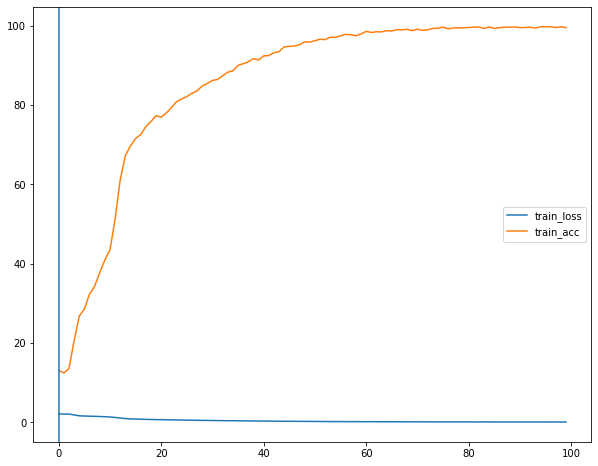

In [20]:
df_training_temp = pd.DataFrame(training_dict)
df_training = df_training_temp.transpose()
df_training.plot(figsize=(10,8))
plt.axvline(x=best_epoch)
plt.show()

In [21]:
print("Best Epoch Training Data: ")
print("Training Loss: ")
print(str(training_dict[best_epoch]['train_loss']))
print("Training Accuracy")
print(str(training_dict[best_epoch]['train_acc']))


Best Epoch Training Data: 
Training Loss: 
2.1082621686002043
Training Accuracy
13.09840425531915


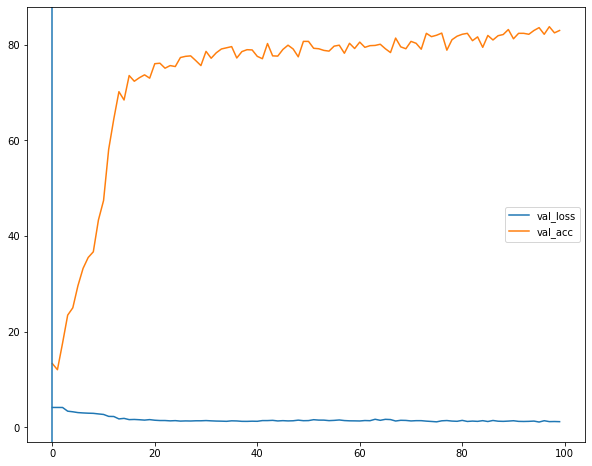

In [22]:
df_validation_temp = pd.DataFrame(validation_dict)
df_validation = df_validation_temp.transpose()
df_validation.plot(figsize=(10,8))
plt.axvline(x=best_epoch)
plt.show()

In [23]:
print("Best Epoch Validation Data: ")
print("Validation Loss: ")
print(str(validation_dict[best_epoch]['val_loss']))
print("Validation Accuracy")
print(str(validation_dict[best_epoch]['val_acc']))

Best Epoch Validation Data: 
Validation Loss: 
4.159022126879011
Validation Accuracy
13.343253968253968


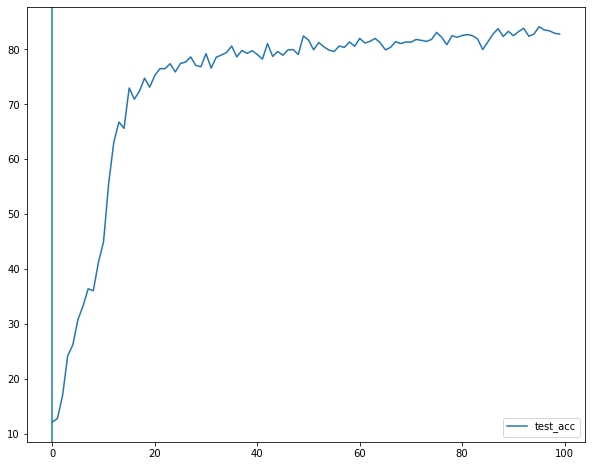

In [24]:
df_testing_temp = pd.DataFrame(testing_dict)
df_testing = df_testing_temp.transpose()
df_testing.plot(figsize=(10,8))
plt.axvline(x=best_epoch)
plt.show()

In [25]:
print("Best Epoch Testing Data: ")
print("Test Accuracy")
print(testing_dict)
print(str(testing_dict[best_epoch]['test_acc']))
epochs = testing_dict.values()
print(max([e['test_acc'] for e in epochs]))

Best Epoch Testing Data: 
Test Accuracy
{0: {'test_acc': 12.152777777777779}, 1: {'test_acc': 12.797619047619047}, 2: {'test_acc': 16.964285714285715}, 3: {'test_acc': 24.206349206349206}, 4: {'test_acc': 26.19047619047619}, 5: {'test_acc': 30.803571428571427}, 6: {'test_acc': 33.28373015873016}, 7: {'test_acc': 36.40873015873016}, 8: {'test_acc': 36.06150793650794}, 9: {'test_acc': 41.220238095238095}, 10: {'test_acc': 44.99007936507937}, 11: {'test_acc': 55.60515873015873}, 12: {'test_acc': 63.095238095238095}, 13: {'test_acc': 66.76587301587301}, 14: {'test_acc': 65.625}, 15: {'test_acc': 72.96626984126983}, 16: {'test_acc': 70.93253968253968}, 17: {'test_acc': 72.37103174603175}, 18: {'test_acc': 74.75198412698413}, 19: {'test_acc': 73.11507936507937}, 20: {'test_acc': 75.24801587301587}, 21: {'test_acc': 76.48809523809524}, 22: {'test_acc': 76.48809523809524}, 23: {'test_acc': 77.38095238095238}, 24: {'test_acc': 75.89285714285714}, 25: {'test_acc': 77.43055555555556}, 26: {'test_